# RAMP on predicting cyclist traffic in Paris

<div>
<table style="width:100%; background-color:transparent;">
  <tr style="background-color:transparent;">
    <td align="left"; style="background-color:transparent; width: 40%;">
        <a href="https://dataia.eu">
            <img src="https://github.com/ramp-kits/bike_counters_skore/raw/main/img/DATAIA-h.png" width="450px"/>
        </a>
    </td>
    <td align="right"; style="background-color:transparent; width: 40%;">
        <a href="https://mdls.fr/">
            <img src="https://github.com/ramp-kits/bike_counters_skore/raw/main/img/probabl_logo.png" width="350px"/>
        </a>
    </td>
  </tr>
 </table>
</div>

Authors: *Roman Yurchak (Symerio), Sylvain Combettes (Probabl), François Caud (DATAIA)*; also partially inspired by the air_passengers starting kit.


## Introduction

The dataset was collected with cyclist counters installed by Paris city council in multiple locations. It contains hourly information about cyclist traffic, as well as the following features,
 - counter name
 - counter site name
 - date
 - counter installation date
 - latitude and longitude
 
Available features are quite scarce. However, **we can also use any external data that can help us to predict the target variable.** 

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

# Loading the data with pandas

First, download the data files with the `download_data` script:
```bash
!conda activate ramp-bike-skore
!python download_data.py
```
It will untar the archive and put the train and test file in the data folder.


Data is stored in [Parquet format](https://parquet.apache.org/), an efficient columnar data format. We can load the train set with pandas,

In [2]:
data = pd.read_parquet(Path("data") / "train.parquet").sort_values(by="date")

In [3]:
data.head()

,counter_id,counter_name,site_id,site_name,bike_count,date,counter_installation_date,counter_technical_id,latitude,longitude,log_bike_count
705677,100056332-104056332,Pont de Bercy SO-NE,100056332,Pont de Bercy,0.0,2020-09-01 01:00:00,2019-12-11,Y2H19070378,48.83848,2.37587,0.000000
333389,100047547-104047547,6 rue Julia Bartet NE-SO,100047547,6 rue Julia Bartet,4.0,2020-09-01 01:00:00,2018-11-28,Y2H18086323,48.82636,2.30303,1.609438
343292,100047547-103047547,6 rue Julia Bartet SO-NE,100047547,6 rue Julia Bartet,2.0,2020-09-01 01:00:00,2018-11-28,Y2H18086323,48.82636,2.30303,1.098612
805911,100057380-103057380,Totem Cours la Reine O-E,100057380,Totem Cours la Reine,0.0,2020-09-01 01:00:00,2020-02-11,YTH19111509,48.86462,2.31444,0.000000
353162,100047548-103047548,Face au 25 quai de l'Oise NE-SO,100047548,Face au 25 quai de l'Oise,2.0,2020-09-01 01:00:00,2018-11-28,Y2H18086324,48.89141,2.38482,1.098612


Now, let us perform some exploratory data analysis on this dataframe:

In [4]:
from skrub import TableReport

TableReport(data)

Processing column  11 / 11


,,,,,,,,,,,


Note that [skrub's TableReport](https://skrub-data.org/stable/reference/generated/skrub.TableReport.html) is interactive and that there are several tabs. For example, in the Stats tab, you can focus on the number of unique entries for each feature.

We have a 30 counting sites where sometimes multiple counters are installed per location.  Let's look at the most frequented stations,

In [5]:
data.groupby(["site_name", "counter_name"], observed=True)[
    "bike_count"
].sum().sort_values(ascending=False).head(10).to_frame()

,,bike_count
site_name,counter_name,
Totem 73 boulevard de Sébastopol,Totem 73 boulevard de Sébastopol S-N,1809231.0
Totem 64 Rue de Rivoli,Totem 64 Rue de Rivoli O-E,1406900.0
Totem 73 boulevard de Sébastopol,Totem 73 boulevard de Sébastopol N-S,1357868.0
67 boulevard Voltaire SE-NO,67 boulevard Voltaire SE-NO,1036575.0
Totem 64 Rue de Rivoli,Totem 64 Rue de Rivoli E-O,914089.0
27 quai de la Tournelle,27 quai de la Tournelle SE-NO,888717.0
Quai d'Orsay,Quai d'Orsay E-O,849724.0
Totem Cours la Reine,Totem Cours la Reine O-E,806149.0
Face au 48 quai de la marne,Face au 48 quai de la marne SO-NE,806071.0


# Visualizing the data


Let's visualize the data, starting from the spatial distribution of counters on the map

In [6]:
import folium

m = folium.Map(location=data[["latitude", "longitude"]].mean(axis=0), zoom_start=13)

for _, row in (
    data[["counter_name", "latitude", "longitude"]]
    .drop_duplicates("counter_name")
    .iterrows()
):
    folium.Marker(
        row[["latitude", "longitude"]].values.tolist(), popup=row["counter_name"]
    ).add_to(m)

m

/home/frcaud/anaconda3/envs/ramp-bike-skore/lib/python3.12/site-packages/folium/utilities.py:93: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coords = (location[0], location[1])


Note that in this RAMP problem we consider only the 30 most frequented counting sites, to limit data size.


Next, we will look into the temporal distribution of the most frequented bike counter. If we plot it directly we will not see much because there are half a million data points,

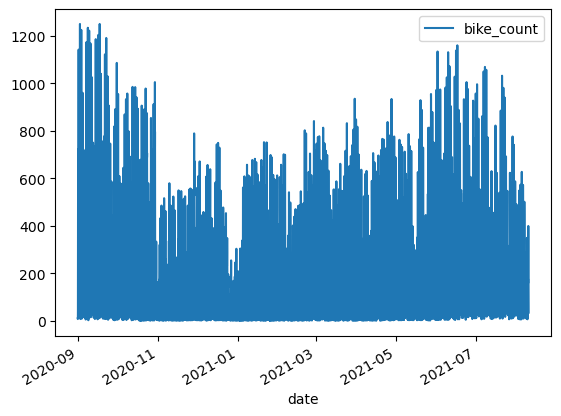

In [7]:
mask = data["counter_name"] == "Totem 73 boulevard de Sébastopol S-N"

data[mask].plot(x="date", y="bike_count")
plt.show()

Instead we aggregate the data, for instance, by week to have a clearer overall picture,

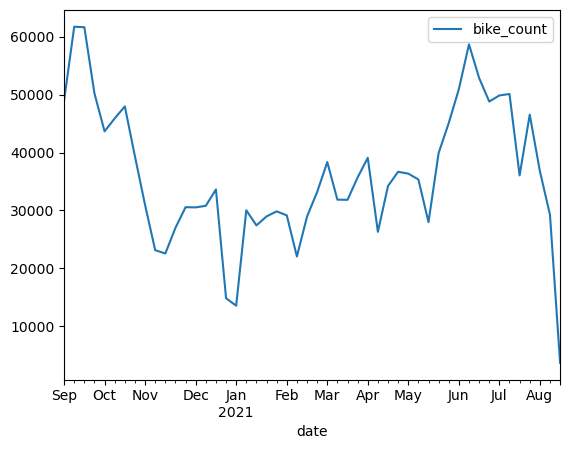

In [8]:
mask = data["counter_name"] == "Totem 73 boulevard de Sébastopol S-N"

data[mask].groupby(pd.Grouper(freq="1W", key="date"))[["bike_count"]].sum().plot()
plt.show()

While at the same time, we can zoom on a week in particular for a more short-term visualization,

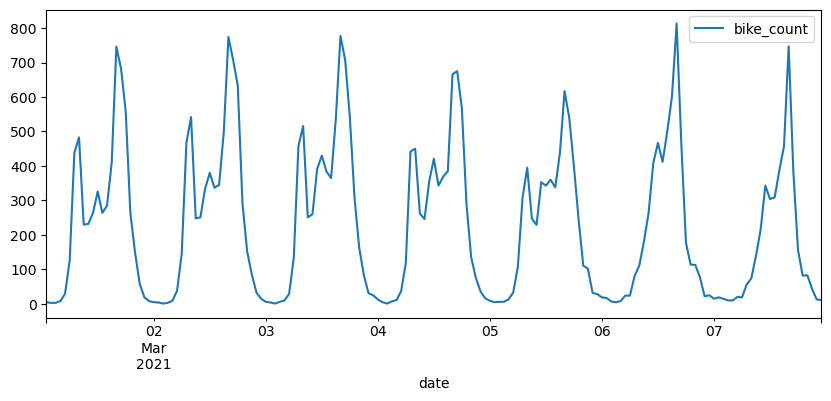

In [9]:
fig, ax = plt.subplots(figsize=(10, 4))

mask = (
    (data["counter_name"] == "Totem 73 boulevard de Sébastopol S-N")
    & (data["date"] > pd.to_datetime("2021/03/01"))
    & (data["date"] < pd.to_datetime("2021/03/08"))
)

data[mask].plot(x="date", y="bike_count", ax=ax)
plt.show()

The hourly pattern has a clear variation between work days and weekends (7 and 8 March 2021).

If we look at the distribution of the target variable it skewed and non normal, 

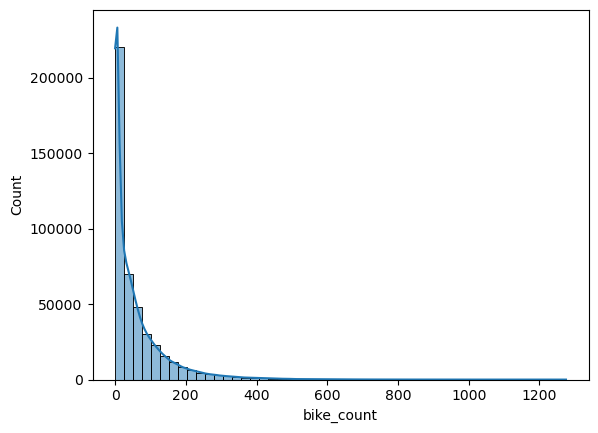

In [10]:
import seaborn as sns

ax = sns.histplot(data, x="bike_count", kde=True, bins=50)

Least square loss would not be appropriate to model it since it is designed for normal error distributions. One way to precede would be to transform the variable with a logarithmic transformation,
```py
data['log_bike_count'] = np.log(1 + data['bike_count'])
```

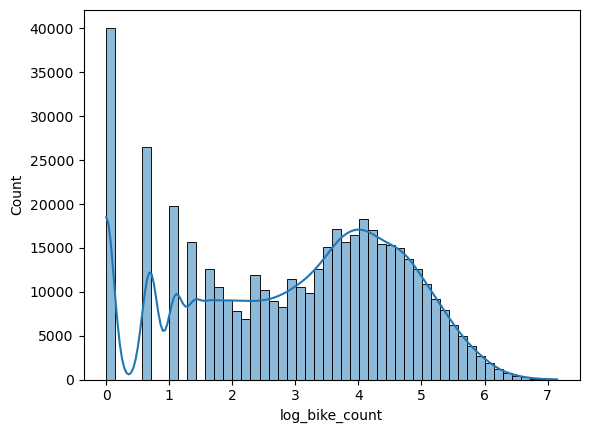

In [11]:
ax = sns.histplot(data, x="log_bike_count", kde=True, bins=50)

which has a more pronounced central mode, but is still non symmetric. In the following, **we use `log_bike_count` as the target variable** as otherwise `bike_count` ranges over 3 orders of magnitude and least square loss would be dominated by the few large values. 

## Feature extraction

To account for the temporal aspects of the data, we cannot input the `date` field directly into the model. Instead we extract the features on different time-scales from the `date` field, 

In [12]:
def _encode_dates(X):
    X = X.copy()  # modify a copy of X
    # Encode the date information from the DateOfDeparture columns
    X.loc[:, "year"] = X["date"].dt.year
    X.loc[:, "month"] = X["date"].dt.month
    X.loc[:, "day"] = X["date"].dt.day
    X.loc[:, "weekday"] = X["date"].dt.weekday
    X.loc[:, "hour"] = X["date"].dt.hour

    # Finally we can drop the original columns from the dataframe
    return X.drop(columns=["date"])

In [13]:
data["date"].head()

705677   2020-09-01 01:00:00
333389   2020-09-01 01:00:00
343292   2020-09-01 01:00:00
805911   2020-09-01 01:00:00
353162   2020-09-01 01:00:00
Name: date, dtype: datetime64[us]

In [14]:
_encode_dates(data[["date"]].head())

,year,month,day,weekday,hour
705677,2020,9,1,1,1
333389,2020,9,1,1,1
343292,2020,9,1,1,1
805911,2020,9,1,1,1
353162,2020,9,1,1,1


To use this function with scikit-learn estimators we wrap it with [FunctionTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.FunctionTransformer.html),

In [15]:
from sklearn.preprocessing import FunctionTransformer

date_encoder = FunctionTransformer(_encode_dates, validate=False)
date_encoder.fit_transform(data[["date"]]).head()

,year,month,day,weekday,hour
705677,2020,9,1,1,1
333389,2020,9,1,1,1
343292,2020,9,1,1,1
805911,2020,9,1,1,1
353162,2020,9,1,1,1


Since it is unlikely that, for instance, that `hour` is linearly correlated with the target variable, we would need to additionally encode categorical features for linear models. This is classically done with [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html), though other encoding strategies exist.

In [16]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(sparse_output=False)

enc.fit_transform(_encode_dates(data[["date"]])[["hour"]].head())

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.]])

## Ridge model

Let's now construct our first linear model with [Ridge](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html). We use a few helper functions defined in `problem.py` of the starting kit to load the public train and test data:

In [17]:
import problem

X_train, y_train = problem.get_train_data()
X_test, y_test = problem.get_test_data()

In [18]:
X_train.head(2)

,counter_id,counter_name,site_id,site_name,date,counter_installation_date,counter_technical_id,latitude,longitude
400125,100049407-353255860,152 boulevard du Montparnasse E-O,100049407,152 boulevard du Montparnasse,2020-09-01 01:00:00,2018-12-07,Y2H19070373,48.840801,2.333233
408305,100049407-353255859,152 boulevard du Montparnasse O-E,100049407,152 boulevard du Montparnasse,2020-09-01 01:00:00,2018-12-07,Y2H19070373,48.840801,2.333233


and

In [19]:
y_train

array([1.60943791, 1.38629436, 0.        , ..., 2.48490665, 1.60943791,
       1.38629436])

Where `y` contains the `log_bike_count` variable. 

The test set is in the future as compared to the train set,

In [20]:
print(
    f'Train: n_samples={X_train.shape[0]},  {X_train["date"].min()} to {X_train["date"].max()}'
)
print(
    f'Test: n_samples={X_test.shape[0]},  {X_test["date"].min()} to {X_test["date"].max()}'
)

Train: n_samples=455163,  2020-09-01 01:00:00 to 2021-08-09 23:00:00
Test: n_samples=41608,  2021-08-10 01:00:00 to 2021-09-09 23:00:00


In [21]:
_encode_dates(X_train[["date"]]).columns.tolist()

['year', 'month', 'day', 'weekday', 'hour']

In [22]:
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline

date_encoder = FunctionTransformer(_encode_dates)
date_cols = _encode_dates(X_train[["date"]]).columns.tolist()

categorical_encoder = OneHotEncoder(handle_unknown="ignore")
categorical_cols = ["counter_name", "site_name"]

preprocessor = ColumnTransformer(
    [
        ("date", OneHotEncoder(handle_unknown="ignore"), date_cols),
        ("cat", categorical_encoder, categorical_cols),
    ]
)

regressor = Ridge()

pipe = make_pipeline(date_encoder, preprocessor, regressor)
pipe

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function _encode_dates at 0x7f207f616980>)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('date',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['year', 'month', 'day',
                                                   'weekday', 'hour']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['counter_name',
                                                   'site_name'])])),
                ('ridge', Ridge())])

### Evaluation

Let us use the estimator report from skore to evaluate our scikit-learn pipeline:

In [23]:
from skore import EstimatorReport

pipe_report = EstimatorReport(
    pipe,
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
)

We display the helper to see what is available to us:

In [24]:
pipe_report.help()

╭───────────────────────── Tools to diagnose estimator Ridge ──────────────────────────╮
│ EstimatorReport                                                                      │
│ ├── .metrics                                                                         │
│ │   ├── .prediction_error(...)         - Plot the prediction error of a regression   │
│ │   │   model.                                                                       │
│ │   ├── .r2(...)               (↗︎)     - Compute the R² score.                       │
│ │   ├── .rmse(...)             (↘︎)     - Compute the root mean squared error.        │
│ │   ├── .timings(...)                  - Get all measured processing times related   │
│ │   │   to the estimator.                                                            │
│ │   ├── .custom_metric(...)            - Compute a custom metric.                    │
│ │   └── .report_metrics(...)           - Report a set of metrics for our estimator.  │
│ ├── .feature_importance                                                              │
│ │   ├── .coefficients(...)             - Retrieve the coefficients of a linear       │
│ │   │   model, including the intercept.                                              │
│ │   └── .permutation(...)              - Report the permutation feature importance.  │
│ ├── .cache_predictions(...)            - Cache estimator's predictions.              │
│ ├── .clear_cache(...)                  - Clear the cache.                            │
│ ├── .get_predictions(...)              - Get estimator's predictions.                │
│ └── Attributes                                                                       │
│     ├── .X_test                        - Testing data                                │
│     ├── .X_train                       - Training data                               │
│     ├── .y_test                        - Testing target                              │
│     ├── .y_train                       - Training target                             │
│     ├── .estimator_                    - The cloned or copied estimator              │
│     ├── .estimator_name_               - The name of the estimator                   │
│     └── .fit_time_                     - The time taken to fit the estimator, in     │
│         seconds                                                                      │
│                                                                                      │
│                                                                                      │
│ Legend:                                                                              │
│ (↗︎) higher is better (↘︎) lower is better                                             │
╰──────────────────────────────────────────────────────────────────────────────────────╯

We evaluate our model on both the $R^2$ and the RMSE, using the metrics accessor:

In [25]:
pipe_report.metrics.report_metrics(data_source="train")

,Ridge
Metric,
R²,0.771475
RMSE,0.800750
Fit time,0.522545
Predict time,0.363927


In [26]:
pipe_report.metrics.report_metrics(data_source="test")

,Ridge
Metric,
R²,0.745980
RMSE,0.725306
Fit time,0.522545
Predict time,0.069358


The model doesn't have enough capacity to generalize on the train set, since we have lots of data with relatively few parameters. However it happened to work somewhat better on the test set. We can compare these results with the baseline predicting the mean value,

In [27]:
from sklearn.dummy import DummyRegressor

dummy_regr = DummyRegressor(strategy="mean")
dummy_report = EstimatorReport(
    dummy_regr,
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
)
df_dummy = pd.concat([
    dummy_report.metrics.report_metrics(data_source="train"),
    dummy_report.metrics.report_metrics(data_source="test"),
], axis=1)
df_dummy.columns = ["DummyRegressor (train)", "DummyRegressor (test)"]
df_dummy

,DummyRegressor (train),DummyRegressor (test)
Metric,,
R²,0.000000,-0.068402
RMSE,1.675057,1.487492
Fit time,0.002327,0.002327
Predict time,0.001583,0.000269


In [28]:
from skore import ComparisonReport

reports_to_compare = {
    "Ridge (manual)": pipe_report,
    "Dummy (mean)": dummy_report,
}
comparator = ComparisonReport(reports=reports_to_compare)
comparator.metrics.report_metrics()

Output()

Estimator,Ridge (manual),Dummy (mean)
Metric,,
R²,0.745980,-0.068402
RMSE,0.725306,1.487492
Fit time,0.522545,0.002327
Predict time,0.069358,0.000269


which illustrates that we are performing better than the baseline.

Let's visualize the predictions for one of the stations,

In [29]:
pipe = pipe_report.estimator_

mask = (
    (X_test["counter_name"] == "Totem 73 boulevard de Sébastopol S-N")
    & (X_test["date"] > pd.to_datetime("2021/09/01"))
    & (X_test["date"] < pd.to_datetime("2021/09/08"))
)

df_viz = X_test.loc[mask].copy()
df_viz["bike_count"] = np.exp(y_test[mask.values]) - 1
df_viz["bike_count (predicted)"] = np.exp(pipe.predict(X_test[mask])) - 1

Text(0, 0.5, 'bike_count')

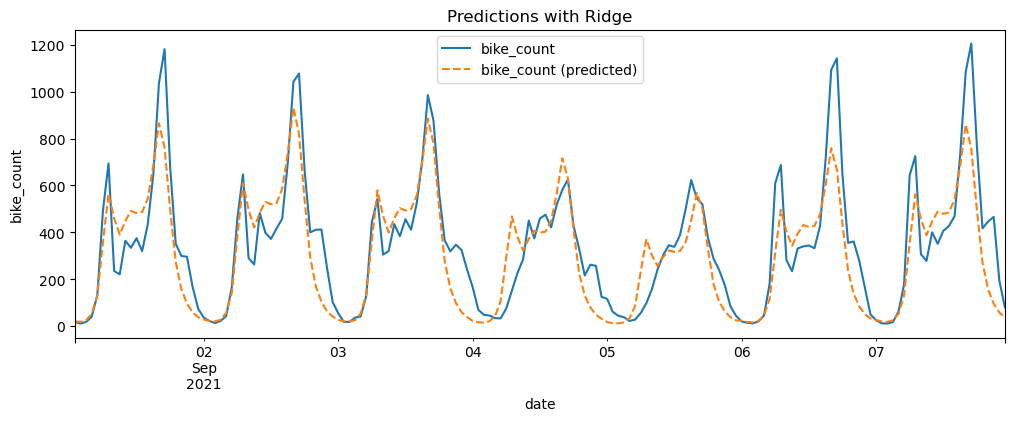

In [30]:
fig, ax = plt.subplots(figsize=(12, 4))

df_viz.plot(x="date", y="bike_count", ax=ax)
df_viz.plot(x="date", y="bike_count (predicted)", ax=ax, ls="--")
ax.set_title("Predictions with Ridge")
ax.set_ylabel("bike_count")

So we start to see the daily trend, and some of the week day differences are accounted for, however we still miss the details and the spikes in the evening are under-estimated.

A useful way to visualize the error is to plot the prediction error,

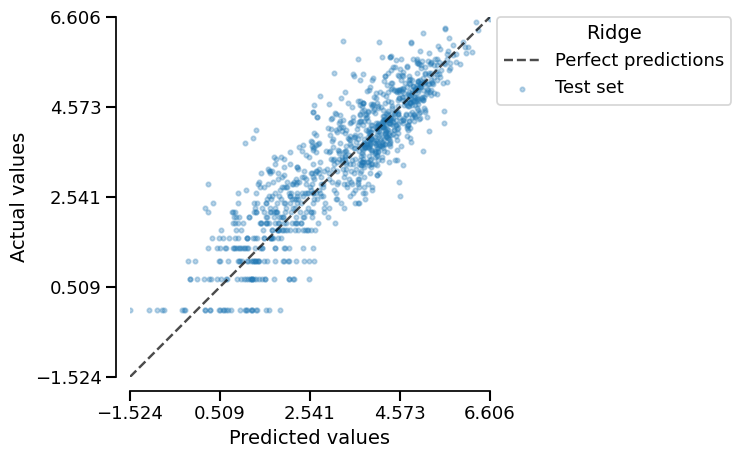

In [31]:
pipe_report.metrics.prediction_error().plot(kind="actual_vs_predicted")

## Linear model from skrub

In [32]:
from skrub import tabular_learner

tab_learner = tabular_learner(Ridge())

tab_report = EstimatorReport(
    tab_learner,
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
)
tab_report.estimator_

Pipeline(steps=[('tablevectorizer',
                 TableVectorizer(datetime=DatetimeEncoder(periodic_encoding='spline'))),
                ('simpleimputer', SimpleImputer(add_indicator=True)),
                ('standardscaler', StandardScaler()), ('ridge', Ridge())])

In [33]:
reports_to_compare["Ridge (skrub baseline)"] = tab_report
comparator = ComparisonReport(reports=reports_to_compare)
comparator.metrics.report_metrics()

Output()

Estimator,Ridge (manual),Dummy (mean),Ridge (skrub baseline)
Metric,,,
R²,0.745980,-0.068402,0.582896
RMSE,0.725306,1.487492,0.929415
Fit time,0.522545,0.002327,102.374699
Predict time,0.069358,0.000269,0.627726


## Tree-based model

In [34]:
hgbt_skrub = tabular_learner("regressor")

hbbt_report = EstimatorReport(
    hgbt_skrub,
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
)
hbbt_report.estimator_

Pipeline(steps=[('tablevectorizer',
                 TableVectorizer(high_cardinality=MinHashEncoder(),
                                 low_cardinality=ToCategorical())),
                ('histgradientboostingregressor',
                 HistGradientBoostingRegressor())])

In [35]:
reports_to_compare["HGBT (skrub baseline)"] = hbbt_report
comparator = ComparisonReport(reports=reports_to_compare)
comparator.metrics.report_metrics()

Output()

Estimator,Ridge (manual),Dummy (mean),Ridge (skrub baseline),HGBT (skrub baseline)
Metric,,,,
R²,0.745980,-0.068402,0.582896,0.774440
RMSE,0.725306,1.487492,0.929415,0.683468
Fit time,0.522545,0.002327,102.374699,7.953445
Predict time,0.069358,0.000269,0.627726,0.326454


## A note on cross-validation

It is recommended to use cross-validation for hyper-parameter tuning with [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) or more reliable model evaluation with [cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn.model_selection.cross_val_score). In this case, because we want the test data to always be in the future as compared to the train data, we can use [TimeSeriesSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html),

<img src="https://i.stack.imgur.com/Q37Bn.png" />

The disadvantage, is that we can either have the training set size be different for each fold which is not ideal for hyper-parameter tuning (current figure), or have constant sized small training set which is also not ideal given the data periodicity. This explains that generally we will have worse cross-validation scores than test scores, 

In [36]:
from sklearn.model_selection import TimeSeriesSplit
from skore import CrossValidationReport

cv = TimeSeriesSplit(n_splits=6)

cv_report = CrossValidationReport(
    pipe, X_train, y_train, cv_splitter=cv
)

Output()

In [37]:
cv_report.help()

╭───────────────────────── Tools to diagnose estimator Ridge ──────────────────────────╮
│ CrossValidationReport                                                                │
│ ├── .metrics                                                                         │
│ │   ├── .prediction_error(...)         - Plot the prediction error of a regression   │
│ │   │   model.                                                                       │
│ │   ├── .r2(...)               (↗︎)     - Compute the R² score.                       │
│ │   ├── .rmse(...)             (↘︎)     - Compute the root mean squared error.        │
│ │   ├── .timings(...)                  - Get all measured processing times related   │
│ │   │   to the estimator.                                                            │
│ │   ├── .custom_metric(...)            - Compute a custom metric.                    │
│ │   └── .report_metrics(...)           - Report a set of metrics for our estimator.  │
│ ├── .cache_predictions(...)            - Cache the predictions for sub-estimators    │
│ │   reports.                                                                         │
│ ├── .clear_cache(...)                  - Clear the cache.                            │
│ ├── .get_predictions(...)              - Get estimator's predictions.                │
│ └── Attributes                                                                       │
│     ├── .X                             - The data to fit                             │
│     ├── .y                             - The target variable to try to predict in    │
│     │   the case of supervised learning                                              │
│     ├── .estimator_                    - The cloned or copied estimator              │
│     ├── .estimator_name_               - The name of the estimator                   │
│     ├── .estimator_reports_            - The estimator reports for each split        │
│     └── .n_jobs                        - Number of jobs to run in parallel           │
│                                                                                      │
│                                                                                      │
│ Legend:                                                                              │
│ (↗︎) higher is better (↘︎) lower is better                                             │
╰──────────────────────────────────────────────────────────────────────────────────────╯

In [38]:
cv_report.metrics.report_metrics(data_source="train")

Output()

Ridge          
                  mean       std
Metric                          
R²            0.819263  0.020461
RMSE          0.710780  0.053518
Fit time      0.307293  0.118548
Predict time  0.196188  0.109959

In [39]:
cv_report.metrics.report_metrics(data_source="test")

Output()

Ridge          
                  mean       std
Metric                          
R²            0.676437  0.077509
RMSE          0.931700  0.081377
Fit time      0.307293  0.118548
Predict time  0.061229  0.017957

In [40]:
cv_report.metrics.report_metrics(data_source="test", aggregate=None)

Output()

Ridge                                                  
              Split #0  Split #1  Split #2  Split #3  Split #4  Split #5
Metric                                                                  
R²            0.660951  0.721467  0.757911  0.742509  0.611206  0.564578
RMSE          0.963112  0.869636  0.853591  0.870083  1.060825  0.972954
Fit time      0.108621  0.263787  0.286475  0.338213  0.406223  0.440441
Predict time  0.096792  0.048952  0.057036  0.055229  0.060040  0.049322